# Optimizers

In [1]:
%load_ext autoreload
%autoreload 2

%matplotlib inline

In [2]:
#export
from exp.nb_08 import *

## Imagenette data

In [3]:
path = datasets.untar_data(datasets.URLs.IMAGENETTE_160)

In [4]:
tfms = [make_rgb, ResizeFixed(128), to_byte_tensor, to_float_tensor]

In [5]:
bs = 128

In [6]:
il = ImageList.from_files(path, tfms=tfms)

In [7]:
sd = SplitData.split_by_func(il, partial(grandparent_splitter, valid_name='val'))

In [8]:
ll = label_by_func(sd, parent_labeler, proc_y=CategoryProcessor())

In [9]:
data = ll.to_databunch(bs, c_in=3, c_out=10, num_workers=4)

In [10]:
nfs = [32, 64, 128, 256]

In [11]:
cbfs = [partial(AvgStatsCallback, accuracy),
        CudaCallback,
        partial(BatchTransformXCallback, norm_imagenette)]

In [12]:
learn, run = get_learn_run(nfs, data, 0.4, conv_layer, cbs=cbfs)

In [13]:
run.fit(1, learn)

train: [1.7565629786625563, tensor(0.3899, device='cuda:0')]
valid: [1.620135009765625, tensor(0.4540, device='cuda:0')]


## Refining the optimizer

In PyTorch `torch.optim` is simply is a dictionary that stores the hyper-parameters and references to the parameters of the model we want to train in parameter groups.

Our optimizer needs a `step` method and a `zero_grad` method. Ours will be more generic as the actual work is done by stepper functions. Want a different optimizer? Just write a new stepper function.

In [14]:
class Optimizer():
    def __init__(self, params, steppers, **defaults):

        self.param_groups = list(params)
        # ensure that this is a list of lists of tensors
        if not isinstance(self.param_groups[0], list):
            self.param_groups = [self.param_groups]
        
        # a dict containing e.g. lr or mom for every param group
        self.hypers = [{**defaults} for p in self.param_groups]
        # unpack so that every group has their own copy of the dict
        # otherwise would have ref to the same
        
        self.steppers = listify(steppers)
        
    def grad_params(self):
        return [(p, hyper) for pg, hyper in zip(self.param_groups, self.hypers) for p in pg if p.grad is not None]
        
    def zero_grad(self):
        for p, hyper in self.grad_params():
            p.grad.detach()
            p.grad.zero_()
            
    def step(self):
        for p, hyper in self.grad_params():
            compose(p, self.steppers, **hyper)

Let's use this to build vanilla SGD:

In [15]:
def sgd_step(p, lr, **kwargs):
    p.data.add_(-lr, p.grad.data)
    return p

Here we use, that our `compose` passes on any keyword arguments it got.

In [16]:
sgd_opt = partial(Optimizer, steppers=[sgd_step])

We have to adapt our callbacks because we have a separate list of dictionaries for our different parameter groups whereas PyTorch has all hyperparameters in the list of param groups:

In [17]:
#export
class Recorder(Callback):
    def begin_fit(self): self.lrs,self.losses = [],[]

    def after_batch(self):
        if not self.in_train: return
        self.lrs.append(self.opt.hypers[-1]['lr'])  # only lr of last layer is recorded
        self.losses.append(self.loss.detach().cpu())        

    def plot_lr  (self): plt.plot(self.lrs)
    def plot_loss(self): plt.plot(self.losses)
        
    def plot(self, skip_last=0):
        losses = [o.item() for o in self.losses]
        n = len(losses)-skip_last
        plt.xscale('log')
        plt.plot(self.lrs[:n], losses[:n])

In [18]:
#export
class ParamScheduler(Callback):
    _order=1
    def __init__(self, pname, sched_funcs):
        self.pname,self.sched_funcs = pname,listify(sched_funcs)

    def begin_batch(self): 
        if not self.in_train: return
        fs = self.sched_funcs
        if len(fs)==1: fs = fs*len(self.opt.param_groups)
        pos = self.n_epochs/self.epochs
        for f,h in zip(fs,self.opt.hypers): 
            h[self.pname] = f(pos)

In [19]:
#export
class LR_Find(Callback):
    _order=1
    def __init__(self, max_iter=100, min_lr=1e-6, max_lr=10):
        self.max_iter,self.min_lr,self.max_lr = max_iter,min_lr,max_lr
        self.best_loss = 1e9
        
    def begin_batch(self): 
        if not self.in_train: return
        pos = self.n_iter/self.max_iter
        lr = self.min_lr * (self.max_lr/self.min_lr) ** pos
        for h in self.opt.hypers: h['lr'] = lr
            
    def after_step(self):
        if self.n_iter>=self.max_iter or self.loss>self.best_loss*10:
            raise CancelTrainException()
        if self.loss < self.best_loss: self.best_loss = self.loss

Let's test this everything still works:

In [20]:
sched = combine_scheds([0.3, 0.7], [sched_cos(0.3, 0.6), sched_cos(0.6, 0.2)])

In [21]:
cbfs = [
    partial(AvgStatsCallback, accuracy),
    CudaCallback, Recorder,
    partial(ParamScheduler, 'lr', sched)
]

In [22]:
learn,run = get_learn_run(nfs, data, 0.4, conv_layer, cbs=cbfs, opt_func=sgd_opt)

In [23]:
%time run.fit(1, learn)

train: [1.7953794824627733, tensor(0.3700, device='cuda:0')]
valid: [1.610393310546875, tensor(0.4460, device='cuda:0')]
CPU times: user 2.66 s, sys: 1.03 s, total: 3.69 s
Wall time: 4.43 s


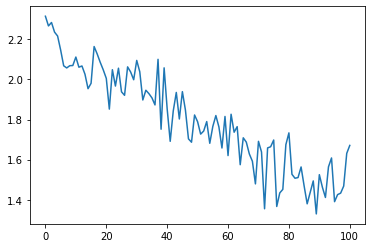

In [24]:
run.recorder.plot_loss()

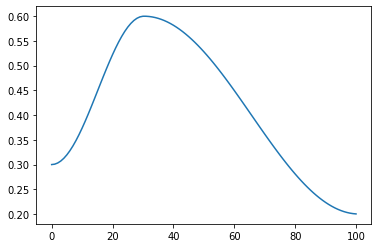

In [25]:
run.recorder.plot_lr()

## Weight decay

** Weight decay:**
`new_weight = weight - lr * weight.grad - lr * wd * weight`

**L2-regularization:**
`weight.grad += wd * weight`

We need to assign a default `wd` to the weight decay function to make sure that the `Optimizer` has a hyper-parameter of the same name even if not specified by the user.

In [26]:
#export
def weight_decay(p, lr, wd, **kwargs):
    p.data.mul_(1 - lr * wd)
    return p

weight_decay._defaults = dict(wd=0.)

In [27]:
weight_decay._defaults

{'wd': 0.0}

L2-regularization would be adding the `wd * weight` to the gradients:

In [28]:
#export
def l2_reg(p, lr, wd, **kwargs):
    p.grad.data.add_(wd, p.data)
    return p
l2_reg._defaults = dict(wd=0.)

We have to allow the steppers to maybe add their `_defaults` to the optimizers `defaults` in case it does not have certain hyper parameters:

In [29]:
#export
def maybe_update(origins, target, get_func):
    for o in origins:  # goes through steppers
        for k, v in get_func(o).items():
            if k not in target: target[k] = v
                
def get_defaults(s): return getattr(s, '_defaults', {})  # return empty dict if stepper does not have _defaults

In [30]:
#export
class Optimizer():
    def __init__(self, params, steppers, **defaults):
        self.steppers = listify(steppers)
        maybe_update(self.steppers, defaults, get_defaults)
        
        self.param_groups = list(params)  # might be a generator
        
        # ensure that this is a list of lists of tensors
        if not isinstance(self.param_groups[0], list):
            self.param_groups = [self.param_groups]
        
        # a dict containing e.g. lr or mom for every param group
        self.hypers = [{**defaults} for p in self.param_groups]
        # unpack so that every group has their own copy of the dict
        # otherwise would have ref to the same
        
        
    def grad_params(self):
        return [(p, hyper) for pg, hyper in zip(self.param_groups, self.hypers) for p in pg if p.grad is not None]
        
    def zero_grad(self):
        for p, hyper in self.grad_params():
            p.grad.detach()
            p.grad.zero_()
            
    def step(self):
        for p, hyper in self.grad_params():
            compose(p, self.steppers, **hyper)

In [31]:
#export
sgd_opt = partial(Optimizer, steppers=[weight_decay, sgd_step])

In [32]:
learn, run = get_learn_run(nfs, data, 0.4, conv_layer, cbs=cbfs, opt_func=sgd_opt)

Let's make sure this works as intended when we don't specify a `wd`:

In [33]:
model = learn.model

In [34]:
opt = sgd_opt(model.parameters(), lr=0.1)
test_eq(opt.hypers[0]['lr'], 0.1)
test_eq(opt.hypers[0]['wd'], 0.0)

In [35]:
opt = sgd_opt(model.parameters(), lr=0.1, wd=1e-4)
test_eq(opt.hypers[0]['lr'], 0.1)
test_eq(opt.hypers[0]['wd'], 1e-4)

In [36]:
opt.hypers

[{'lr': 0.1, 'wd': 0.0001}]

In [37]:
cbfs = [partial(AvgStatsCallback,accuracy), CudaCallback]

In [38]:
learn, run = get_learn_run(nfs, data, 0.4, conv_layer, cbs=cbfs, opt_func=sgd_opt)

In [39]:
run.fit(1, learn)

train: [1.8045534441891578, tensor(0.3693, device='cuda:0')]
valid: [1.53781494140625, tensor(0.4700, device='cuda:0')]


## With momentum

We need to save the moving average of the gradients as state to be able to do the update step. For this purpose we introduce statistics which have two methods:

* `init_state` returns the initial state, a tensor with zeros, for the moving average of the gradients.
* `update` updates the state with the new gradient value

In [40]:
#export
class StatefulOptimizer(Optimizer):
    def __init__(self, params, steppers, stats=None, **defaults):
        self.stats = listify(stats)
        maybe_update(self.stats, defaults, get_defaults)
        super().__init__(params, steppers, **defaults)
        self.state = {}
        
    def step(self):
        for p, hyper in self.grad_params():
            if p not in self.state:
                # Create a state for p and call all the statistics to initialize it.
                self.state[p] = {}
                maybe_update(self.stats, self.state[p], lambda o: o.init_state(p))
            state = self.state[p]
            for stat in self.stats:
                state = stat.update(p, state, **hyper)  # update the dict state using p
            compose(p, self.steppers, **state, **hyper)
            self.state[p] = state

In [41]:
#export
class Stat():
    _defaults = {}
    def init_state(self, p): raise NotImplementedError
    def update(self, state, **kwargs): raise NotImplementedError

In [42]:
class AverageGrad(Stat):
    _defaults = dict(mom=0.9)
    
    def init_state(self, p): return {'grad_avg': torch.zeros_like(p.grad.data)}
    
    def update(self, p, state, mom, **kwargs):
        state['grad_avg'].mul_(mom).add_(p.grad.data)  # there is probably a * (1-mom) missing here I'd say
        return state

Let's add the momentum step. Instead of the gradients we use the average to perform the update step:

In [43]:
#export
def momentum_step(p, lr, grad_avg, **kwargs):
    p.data.add_(-lr, grad_avg)
    return p

In [44]:
sgd_mom_opt = partial(StatefulOptimizer, steppers=[momentum_step, weight_decay], stats=[AverageGrad()], wd=0.01)

In [45]:
learn, run = get_learn_run(nfs, data, 0.3, conv_layer, cbs=cbfs, opt_func=sgd_mom_opt)

In [46]:
run.fit(1, learn)

train: [1.7831810095780984, tensor(0.3876, device='cuda:0')]
valid: [1.777040283203125, tensor(0.3860, device='cuda:0')]


## Momentum experiments

In [70]:
x = torch.linspace(-4, 4, 200)
y = torch.randn(200) + 0.3
betas = [0.5, 0.7, 0.9, 0.99]

In [71]:
def plot_mom(f):
    _, axs = plt.subplots(2, 2, figsize=(12,8))
    for beta, ax in zip(betas, axs.flatten()):
        ax.plot(y, linestyle='None', marker='.')
        avg, res = None, []
        for i, yi in enumerate(y):
            avg, p = f(avg, beta, yi, i)
            res.append(p)
        ax.plot(res, color='red')
        ax.set_title(f'beta={beta}')

Regular momentum:

In [72]:
def mom1(avg, beta, yi, i):
    if avg is None: avg = yi
    res = beta*avg + yi
    return res, res

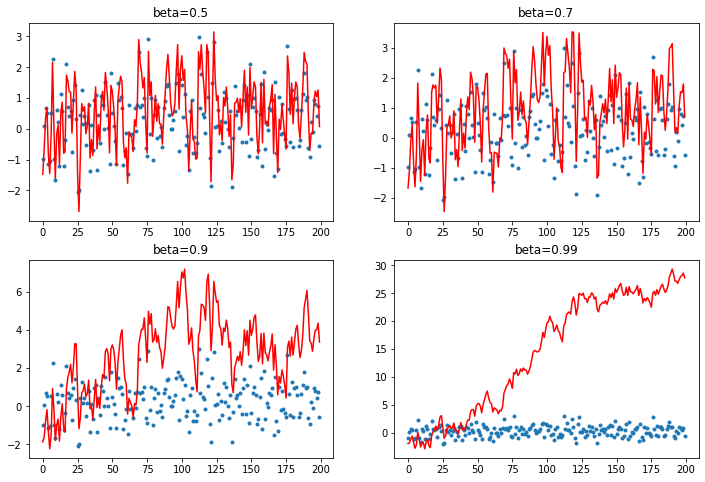

In [73]:
plot_mom(mom1)

As expected, if beta is too large, we keep adding too much on top of `avg` and the number gets unreasonably large. => High momentum is dangerous.

Let's visualize the gradient changing direction and "the optimizer turning around" with momentum enabled:

In [76]:
y1 = torch.randn(100) + 0.3
y2 = torch.randn(100) - 0.3

In [82]:
y = torch.cat([y1,y2])

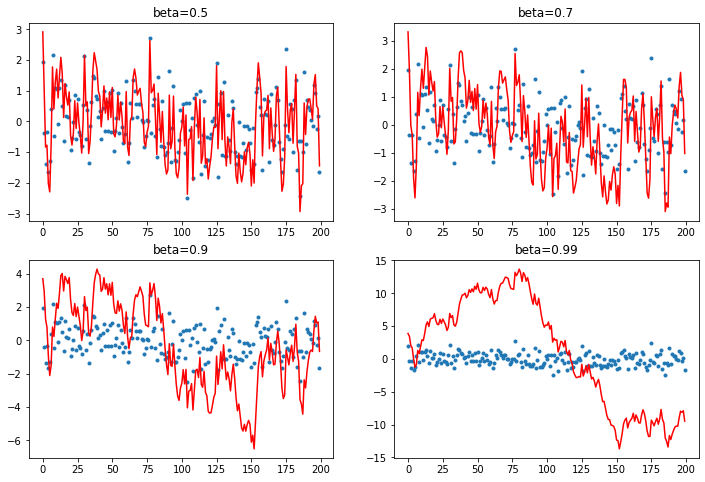

In [83]:
plot_mom(mom1)

The plot on the bottom right nicely visualizes how the optimizer has some momentum but then "turns around" because "the direction of the gradient changed".

Let's do an exponentially weighted moving average as another way of smoothing:

In [88]:
y = torch.randn(200) + 0.3

In [89]:
#export
def lin_comb(v1, v2, beta):
    return v1*beta + (1-beta)*v2

In [90]:
def mom2(avg, beta, yi, i):
    if avg is None: avg = yi
    res = lin_comb(avg, yi, beta)
    return res, res

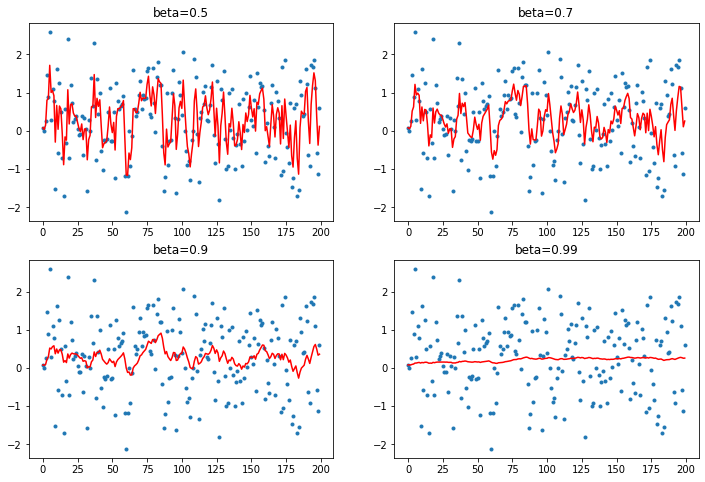

In [91]:
plot_mom(mom2)

The higher beta, the less we trust each new gradient (or in this case `yi`). The new gradient/`yi` is dampened with `(1-beta)`, thus, the larger beta, the smoother the curve becomes.

If the data has a certain shape (symbolizing that the gradient changes over time) the running average will follow that shape with some delay which is larger, the higher beta is:

In [93]:
y = 1 - (x/3) ** 2 + torch.randn(200) * 0.1

In [94]:
y[0] = 0.5

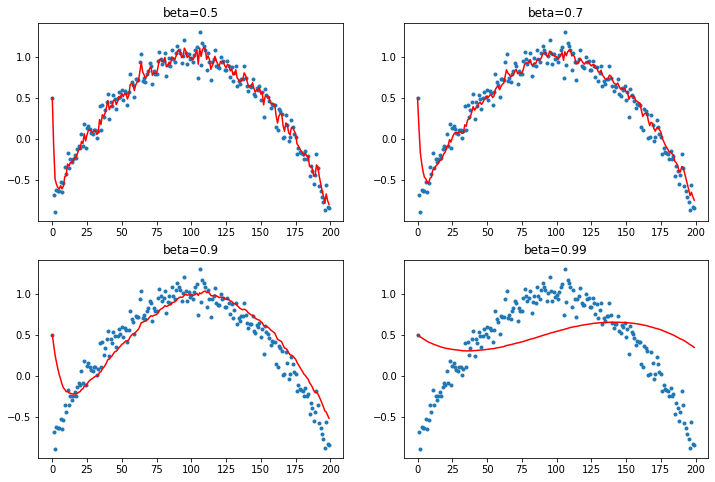

In [105]:
plot_mom(mom2)

The higher beta, the less important every new gradient is, and the more "inertia the optimizer has". 

### Debiasing

Debiasing is here to correct the wrong information we may have in the very first batch. The debias term corresponds to the sum of the coefficient in our moving average. At the time step i, our average is:
\begin{align*}
    avg_{i} &= \beta\ avg_{i-1} + (1-\beta)\ v_{i} = \beta\ (\beta\ avg_{i-2} + (1-\beta)\ v_{i-1}) + (1-\beta)\ v_{i} \\
    &= \beta^{2}\ avg_{i-2} + (1-\beta)\ \beta\ v_{i-1} + (1-\beta)\ v_{i} \\
    &= \beta^{3}\ avg_{i-3} + (1-\beta)\ \beta^{2}\ v_{i-2} + (1-\beta)\ \beta\ v_{i-1} + (1-\beta)\ v_{i} \\
    &\vdots \\
    &= (1-\beta)\ \beta^{i}\ v_{0} + (1-\beta)\ \beta^{i-1}\ v_{1} + \cdots + (1-\beta)\ \beta^{2}\ v_{i-2} + (1-\beta)\ \beta\  v_{i-1} + (1-\beta)\ v_{i}
    \end{align*}

and so the sum of the coefficients is

\begin{align*}
S &=(1-\beta)\ \beta^{i} + (1-\beta)\ \beta^{i-1} + \cdots + (1-\beta)\ \beta^{2} + (1-\beta)\ \beta + (1-\beta) \\
    &= (\beta^{i} - \beta^{i+1}) + (\beta^{i-1} - \beta^{i}) + \cdots + (\beta^{2} - \beta^{3}) + (\beta - \beta^{2}) + (1-\beta) \\
    &= 1 - \beta^{i+1}
    \end{align*}
since all the other terms cancel out each other.
 
By dividing by this term, we make our moving average a true average (in the sense that all the coefficients we used for the average sum up to 1).

In [108]:
def mom3(avg, beta, yi, i):
    if avg is None: avg = 0
    avg = lin_comb(avg, yi, beta)
    return avg, avg/(1 - beta ** (i+1))

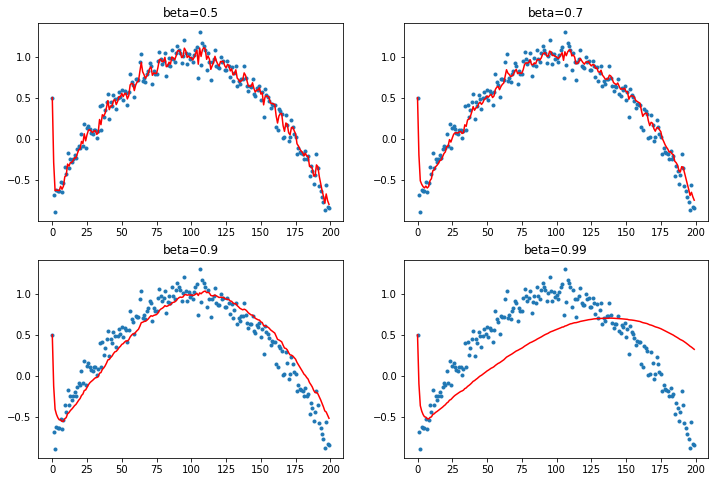

In [109]:
plot_mom(mom3)

## Adam and his friends

In Adam we use gradient averages but with dampening (not like in SGD):

In [110]:
#export
class AverageGrad(Stat):
    _defaults = dict(mom=0.9)
    
    def __init__(self, dampening:bool=False):
        self.dampening = dampening
    
    def init_state(self, p):
        return {'grad_avg': torch.zeros_like(p.grad.data)}
    
    def update(self, p, state, mom, **kwargs):
        state['mom_damp'] = 1.-mom if self.dampening else 1.
        state['grad_avg'].mul_(mom).add_(state['mom_damp'], p.grad.data)
        return state

In [111]:
#export
class AvgerageSqrGrad(Stat):
    _defaults = dict(sqr_mom=0.99)
    
    def __init__(self, dampening:bool=True):
        self.dampening = dampening
        
    def init_state(self, p):
        return {'sqr_avg': torch.zeros_like(p.grad.data)}
    
    def update(self, p, state, sqr_mom, **kwargs):
        state['sqr_damp'] = 1.-sqr_mom if self.dampening else 1.
        state['sqr_avg'].mul_(sqr_mom).addcmul_(state['sqr_damp'], p.grad.data, p.grad.data)
        return state

In [112]:
#export
class StepCount(Stat):
    def init_state(self, p):
        return {'step': 0}
    
    def update(self, p, state, **kwargs):
        state['step'] += 1
        return state

Helper method to compute the debias term: 

* With dampening: `damp=1 - mom`
* Without dampening: `damp=1`

In [150]:
#export
def debias(mom, damp, step):
    return damp * (1 - mom**step) / (1-mom)

In [151]:
#export
def adam_step(p, lr, mom, mom_damp, step, sqr_mom, sqr_damp, grad_avg, sqr_avg, eps, **kwargs):
    debias1 = debias(mom,     mom_damp, step)
    debias2 = debias(sqr_mom, sqr_damp, step)
    
    p.data.addcdiv_(-lr / debias1, grad_avg, (sqr_avg/debias2).sqrt() + eps)
    return p

adam_step._defaults=dict(eps=1e-5)

In [152]:
#export
def adam_opt(xtra_step=None, **kwargs):
    return partial(StatefulOptimizer, steppers=[adam_step, weight_decay]+listify(xtra_step), 
                   stats=[AverageGrad(dampening=True), AvgerageSqrGrad(), StepCount()], **kwargs)

In [153]:
learn,run = get_learn_run(nfs, data, 0.001, conv_layer, cbs=cbfs, opt_func=adam_opt())

In [154]:
run.fit(3, learn)

train: [1.7811783520920583, tensor(0.3817, device='cuda:0')]
valid: [1.48293701171875, tensor(0.5120, device='cuda:0')]
train: [1.271636759345432, tensor(0.5813, device='cuda:0')]
valid: [1.270866455078125, tensor(0.5660, device='cuda:0')]
train: [0.9892466790513029, tensor(0.6757, device='cuda:0')]
valid: [1.081831787109375, tensor(0.6380, device='cuda:0')]


## Lamb

It's then super easy to implement a new optimizer. This is LAMB from a [very recent paper](https://arxiv.org/pdf/1904.00962.pdf):
    \begin{align}
    g_{t}^{l} &= \nabla L(w_{t-1}^{l}, x_{t}) \\
    m_{t}^{l} &= \beta_{1} m_{t-1}^{l} + (1-\beta_{1}) g_{t}^{l} \\
    v_{t}^{l} &= \beta_{2} v_{t-1}^{l} + (1-\beta_{2}) g_{t}^{l} \odot g_{t}^{l} \\
    m_{t}^{l} &= m_{t}^{l} / (1 - \beta_{1}^{t}) \\
    v_{t}^{l} &= v_{t}^{l} / (1 - \beta_{2}^{t}) \\
    r_{1} &= \|w_{t-1}^{l}\|_{2} \\
    s_{t}^{l} &= \frac{m_{t}^{l}}{\sqrt{v_{t}^{l}}+ \epsilon} + \lambda w_{t-1}^{l} \\
    r_{2} &= \| s_{t}^{l} \|_{2} \\
    \eta^{l} &= \eta * r_{1}/r_{2} \\
    w_{t}^{l} &= w_{t}^{l-1} - \eta_{l} * s_{t}^{l} \\
    \end{align}

In [178]:
def lamb_step(p, lr, mom, mom_damp, step, sqr_mom, sqr_damp, grad_avg, sqr_avg, eps, wd, **kwargs):
    debias1 = debias(mom,     mom_damp, step)
    debias2 = debias(sqr_mom, sqr_damp, step)
    r1 = p.data.pow(2).mean().sqrt()  # average over entire parameter
    step = (grad_avg/debias1) / ((sqr_avg/debias2).sqrt()+eps) + wd*p.data
    r2 = step.pow(2).mean().sqrt()
    # average the stepsize scaling over the entire parameter. Smoothes things.

    p.data.add_(-lr * min(r1/r2,10), step)
    return p

lamb_step._defaults = dict(eps=1e-6, wd=0.)

In [179]:
lamb = partial(StatefulOptimizer, steppers=[lamb_step], stats=[AverageGrad(dampening=True), AvgerageSqrGrad(), StepCount()])

In [180]:
learn,run = get_learn_run(nfs, data, 0.003, conv_layer, cbs=cbfs, opt_func=lamb)

In [181]:
run.fit(3, learn)

train: [1.906727147801303, tensor(0.3253, device='cuda:0')]
valid: [1.5319500732421876, tensor(0.4600, device='cuda:0')]
train: [1.3725139842174654, tensor(0.5493, device='cuda:0')]
valid: [1.19858203125, tensor(0.6120, device='cuda:0')]
train: [1.057240998114433, tensor(0.6552, device='cuda:0')]
valid: [1.053486328125, tensor(0.6320, device='cuda:0')]


## Export


In [182]:
!python notebook2script.py 09_optimizers.ipynb

Converted 09_optimizers.ipynb to exp/nb_09.py
